In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST, SVHN
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from scripts.plot_loss import plot_losses
from scripts.train_model import train
import warnings

warnings.filterwarnings("ignore")

In [2]:
transform = T.Compose([T.ToTensor(), T.Resize((32, 32))])
train_set = MNIST('MNIST', transform=transform, train=True, download=False)
test_set = MNIST('MNIST', transform=transform, train=False, download=False)

In [3]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [4]:
class LeNet(nn.Module):
    def __init__(self, image_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(  # 32 x 32
            nn.Conv2d(in_channels=image_channels, out_channels=6, kernel_size=5),  # 28 x 28
            nn.Tanh(),
            nn.AvgPool2d(2),  # 14 x 14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),  # 10 x 10
            nn.Tanh(),
            nn.AvgPool2d(2),  # 5 x 5
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)  # 1 x 1
        )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10)
        )
    
    def forward(self, x):
        # x: B x 1 x 32 x 32
        out = self.encoder(x)
        # out: B x 120 x 1 x 1
        out = out.squeeze(-1).squeeze(-1)
        # out: B x 120
        out = self.head(out)
        # out: B x 10
        return out

In [5]:
NUM_EPOCHS = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

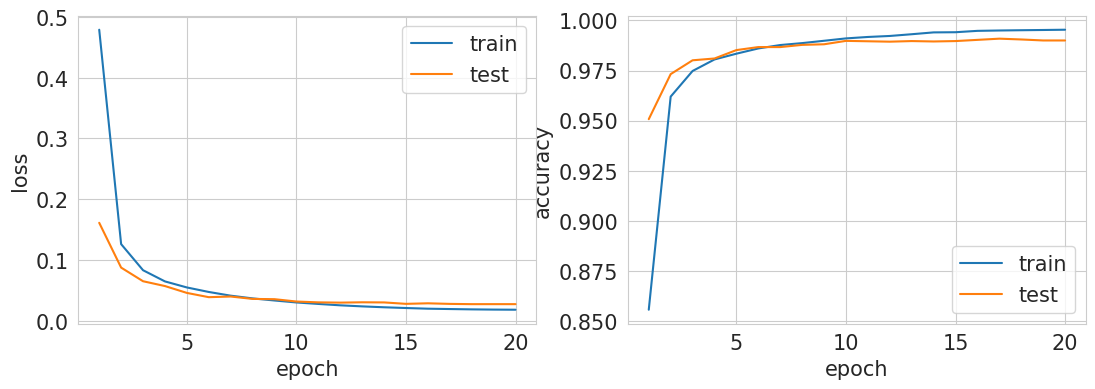

In [7]:
train(NUM_EPOCHS=NUM_EPOCHS, device=device, model=model, optimizer=optimizer, scheduler=scheduler, 
      criterion=criterion, train_loader=train_loader, test_loader=test_loader)

In [9]:
!rm -r MNIST
torch.cuda.empty_cache() 